In [ ]:
! mkdir TRAIN
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
! mv images.raw.gz TRAIN
! mv track_parms.csv TRAIN
! mkdir VALIDATION
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/track_parms.csv
! mv images.raw.gz VALIDATION
! mv track_parms.csv VALIDATION

In [ ]:
import os
import sys
import gzip
import pandas as pd
import numpy as np
import math

width  = 36
height = 100

# Open labels files so we can get number of samples and pass the
# data frames to the generators later
traindf = pd.read_csv('TRAIN/track_parms.csv')
valdf = pd.read_csv('VALIDATION/track_parms.csv')
STEP_SIZE_TRAIN = len(traindf)/32
STEP_SIZE_VAL = len(valdf)/32

#-----------------------------------------------------
# generate_arrays_from_file
#-----------------------------------------------------
# Create generator to read in images and labels
# (used for both training and validation samples)
def generate_arrays_from_file( labelsdf , dType):

	images_path = dType+'images.raw.gz'
	print( 'generator created for: ' + images_path)

	batch_input           = []
	batch_labels_phi      = []
	batch_labels_z        = []
	idx = 0
	ibatch = 0
	while True:  # loop forever, re-reading images from same file
		with gzip.open(images_path) as f:
			while True: # loop over images in file
			
				# Read in one image
				bytes = f.read(width*height)
				if len(bytes) != (width*height): break # break into outer loop so we can re-open file
				data = np.frombuffer(bytes, dtype='B', count=width*height)
				pixels = np.reshape(data, [width, height, 1], order='F')
				pixels_norm = np.transpose(pixels.astype(np.float) / 255., axes=(1, 0, 2) )
				
				# Labels
				phi = labelsdf.phi[idx]
				z   = labelsdf.z[idx]
				idx += 1

				# Add to batch and check if it is time to yield
				batch_input.append( pixels_norm )
				batch_labels_phi.append( phi )
				batch_labels_z.append( z )
				if len(batch_input) == 32 :
					ibatch += 1
					
					# Since we are training multiple loss functions we must
					# pass the labels back as a dictionary whose keys match
					# the layer their corresponding values are being applied to.
					labels_dict = {
						'phi_output' :  np.array(batch_labels_phi ),
						'z_output'   :  np.array(batch_labels_z   ),		
					}
					
					yield ( np.array(batch_input), labels_dict )
					batch_input      = []
					batch_labels_phi = []
					batch_labels_z   = []

			idx = 0
			f.close()


In [ ]:
import requests
import gzip
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

In [ ]:
def buildBranch(input):
  x = keras.layers.Conv2D(32,(3,3),activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Dense(128,activation='relu')(x)
  
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(32, activation="linear",name="common_out")(x)
  return x

def buildPhiBranch(branch):
  x = keras.layers.Dense(64, activation='relu', name="phi_dense1")(branch)
  x = keras.layers.Dense(128, activation='relu', name="phi_dense2")(x)
  x = keras.layers.Dense(64, activation='relu', name="phi_dense3")(x)
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(x)
  return x

def buildZBranch(branch, arg):
  x = keras.layers.concatenate([branch,arg])
  x = keras.layers.Dense(64, activation='relu', name="z_dense1")(x)
  x = keras.layers.Dense(128, activation='relu', name="z_dense2")(x)
  x = keras.layers.Dense(128, activation='relu', name="z_dense3")(x)
  x = keras.layers.Dense(32, activation='relu', name="z_dense4")(x)
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

inputs = keras.Input(shape=(100, 36, 1))
branch = buildBranch(inputs)
branch_phi = buildPhiBranch(branch)
branch_z = buildZBranch(branch,branch_phi)
# branch_phi = keras.layers.Dense(1,activation="linear",name="phi_output")(branch)
# branch_z = keras.layers.Dense(1,activation="linear",name="z_output")(branch)
# branch_z = buildBranch(inputs,"z_output")
# branch_phi = buildBranch(inputs,"phi_output")
model = keras.Model(inputs=inputs, outputs={"phi_output":branch_phi,"z_output":branch_z}, name="detector")
losses = {
    "phi_output":"mse",
    "z_output":"mse"
}
loss_weights = {
    "phi_output":1/10.5,
    "z_output":1/7.5
}
model.compile(optimizer="adam", loss=losses, loss_weights=loss_weights, metrics=["mae"])
# model.compile(optimizer="adam", loss=losses, metrics=["mae"])
model.summary()

Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 36, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 34, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 98, 34, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 98, 34, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [ ]:
train_generator = generate_arrays_from_file(traindf,"TRAIN/")
val_generator = generate_arrays_from_file(valdf,"VALIDATION/")

In [ ]:
# H = model.fit_generator(generator=train_generator,
#                         steps_per_epoch=200,
#                         epochs=25,
#                         use_multiprocessing=False
# )
H = model.fit(x=train_generator,
              validation_data=val_generator,
              steps_per_epoch=100,
              validation_steps=20,
              epochs=500,
              verbose=2
)
model.save("model.keras",save_format="h5")

generator created for: TRAIN/images.raw.gz
Epoch 1/500
generator created for: VALIDATION/images.raw.gz
100/100 - 2s - loss: 2.3875 - phi_output_loss: 1.5436 - z_output_loss: 16.8035 - phi_output_mae: 0.6962 - z_output_mae: 3.4110 - val_loss: 5.3474 - val_phi_output_loss: 30.1858 - val_z_output_loss: 18.5443 - val_phi_output_mae: 4.6922 - val_z_output_mae: 3.7489
Epoch 2/500
100/100 - 2s - loss: 1.3517 - phi_output_loss: 0.4298 - z_output_loss: 9.8306 - phi_output_mae: 0.5148 - z_output_mae: 2.3944 - val_loss: 5.4321 - val_phi_output_loss: 31.6366 - val_z_output_loss: 18.1431 - val_phi_output_mae: 4.9155 - val_z_output_mae: 3.7128
Epoch 3/500
100/100 - 2s - loss: 0.9409 - phi_output_loss: 0.2540 - z_output_loss: 6.8754 - phi_output_mae: 0.3893 - z_output_mae: 1.8985 - val_loss: 4.8134 - val_phi_output_loss: 28.1015 - val_z_output_loss: 16.0278 - val_phi_output_mae: 4.5719 - val_z_output_mae: 3.4569
Epoch 4/500
100/100 - 2s - loss: 0.7330 - phi_output_loss: 0.1907 - z_output_loss: 5.3611

dict_keys(['loss', 'phi_output_loss', 'z_output_loss', 'phi_output_mae', 'z_output_mae', 'val_loss', 'val_phi_output_loss', 'val_z_output_loss', 'val_phi_output_mae', 'val_z_output_mae'])


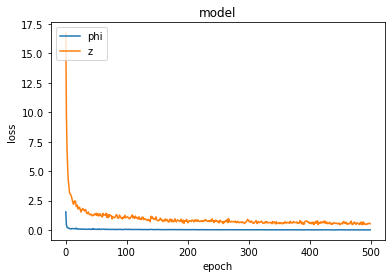

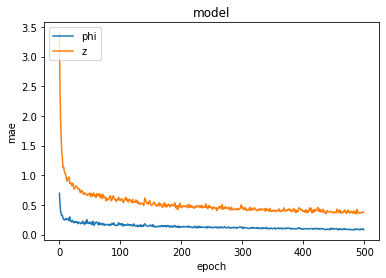

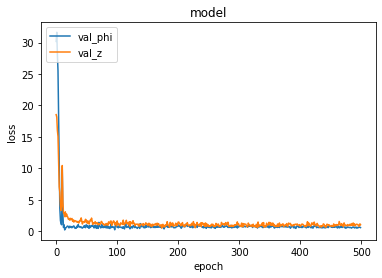

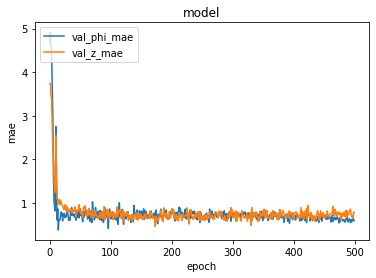

In [ ]:
print(H.history.keys())
try:
  plt.plot(H.history['phi_output_loss'])
  plt.plot(H.history['z_output_loss'])
  plt.title('model')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['phi','z'],loc='upper left')
  plt.show()

  plt.plot(H.history['phi_output_mae'])
  plt.plot(H.history['z_output_mae'])
  plt.title('model')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['phi','z'],loc='upper left')
  plt.show()


  plt.plot(H.history['val_phi_output_loss'])
  plt.plot(H.history['val_z_output_loss'])
  plt.title('model')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['val_phi','val_z'],loc='upper left')
  plt.show()

  plt.plot(H.history['val_phi_output_mae'])
  plt.plot(H.history['val_z_output_mae'])
  plt.title('model')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['val_phi_mae','val_z_mae'],loc='upper left')
  plt.show()
except e:
  print("error:")
  print(e)

### Seems like it doesn't learn well for the z value...



In [ ]:
test_generator = generate_arrays_from_file(valdf,"VALIDATION/")

1/1 [==============================] - 0s 4ms/step
phi:::



z::::

(32, 1)  :  (32, 1)


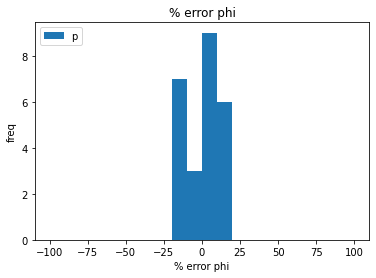

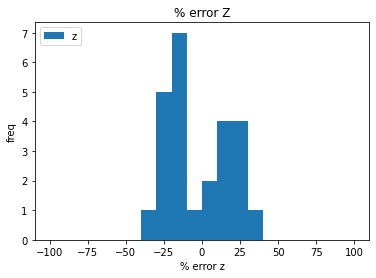

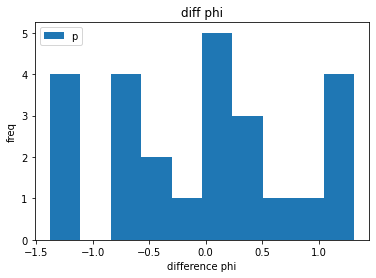

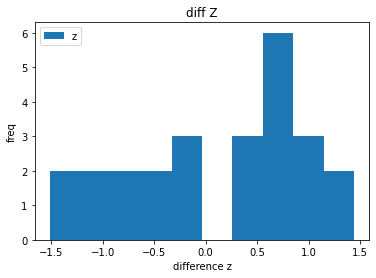

In [ ]:
ev = model.evaluate(test_generator,steps=100,batch_size=32)

test = next(test_generator)
test = np.array(test)
test_x = test[0]
test_y = test[1]

pred = model.predict(x=test_x,verbose=1)

prt = False


print("phi:::\n")
diff_phi = []
diff_phi_err = []
for i in range(25):
  true = np.reshape(test_y["phi_output"],[32,1])[i]
  exp = pred["phi_output"][i]
  diff_phi.append(exp-true)
  # diff_phi_err.append(((true-exp)/exp)*100)
  diff_phi_err.append((abs(exp-true)/true)*100)
  if prt: print(exp," : ",true," : ",diff_phi[-1])

print("\n\nz::::\n")
diff_z = []
diff_z_err = []
for i in range(25):
  true = np.reshape(test_y["z_output"],[32,1])[i]
  exp = pred["z_output"][i]
  diff_z.append(exp-true)
  # diff_z_err.append(((true-exp)/exp)*100)
  diff_z_err.append((abs(exp-true)/true)*100)
  if prt: print(exp," : ",true," : ",diff_z[-1])

print(pred["phi_output"].shape," : ",np.reshape(test_y["phi_output"],[32,1]).shape)
diff_phi = np.array(diff_phi)
diff_z = np.array(diff_z)
diff_phi_err = np.array(diff_phi_err)
diff_z_err = np.array(diff_z_err)

# plt.hist(diff_phi,10)
plt.hist(diff_phi_err,20,[-100,100])
plt.title('% error phi')
plt.ylabel('freq')
plt.xlabel('% error phi')
plt.legend('phi',loc='upper left')
plt.show()

# plt.hist(diff_z,10)
plt.hist(diff_z_err,20,[-100,100])
plt.title('% error Z')
plt.ylabel('freq')
plt.xlabel('% error z')
plt.legend('z',loc='upper left')
plt.show()


plt.hist(diff_phi,10)
plt.title('diff phi')
plt.ylabel('freq')
plt.xlabel('difference phi')
plt.legend('phi',loc='upper left')
plt.show()

plt.hist(diff_z,10)
plt.title('diff Z')
plt.ylabel('freq')
plt.xlabel('difference z')
plt.legend('z',loc='upper left')
plt.show()